# All Star Prediction Model

#### This notebook will construct a predictive machine learning model building upon the previous steps taken in this project. It will be used to predict the all stars of any given year, including the 2024 season when the time comes. In addition, its accuracy may identify deserving players that were snubbed from the game. 

Notes: 
- The goal for the upcoming model will focus more on per game/per minute/per possession type of statistics because the data includes full-season totals and awards that will not be useful when predicting next years all-stars with data from the first half of the season.
- Only 24 all stars will be predicted (12 from each conference). Sometimes there are more because of injuries, so to check accuracy, I will only check if the players the model predicted are all-stars and not fault it for missing the added players. 
- This will built similarly to the process in hof_model.ipynb. I plan to start with a Random Forest model because this data is fairly similar to that of the HOF model, and it worked well for that. A Logistic Regression will be worth testing as well. 

In [92]:
# import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

All-star selections are based on just the current season, so I need to read in my seasons data. I will be using the modern_seasons data because it removed all null values. This cut the seasons off at 1980 because that is when the 3pt line was introduced - anything before that had null values. 

In [93]:
seasons = pd.read_csv('modern_seasons.csv')

Before I make any models, I am going to make a function that will be responsible for scoring the effectiveness of the model. I think an important metric for scoring is predicted all-star precision, the percent accuracy of predicted all-stars (only predicted Trues). This is because there are often more than 24 all-stars due to injury substitutions, which would inherently drop the accuracy when I am predicting exactly 24 each year. Therefore, I will focus on the correctness of the players I predicted, rather than the percentage of the actual all-stars that I identified. 
- Example: if I predict 24 all-stars and all of them are all-stars, my score is 100%, even if there was actually 26 all-stars that year.

I am also not particularly interested in players that were not all-stars so this should work as a scoring measure. 

In [94]:
def predicted_AS_precision(test_results):
    true_positives = test_results[test_results['all star'] & test_results['predicted']]
    # Calculate the accuracy rate among the predicted All-Stars
    precision_rate = len(true_positives) / len(test_results[test_results['predicted']])
    return precision_rate

# Model 1

My first model will be a trial run where every explanatory variable from the data is used, including basic, advanced, and team stats. I expect it to work decently well because I tailored the data set towards this goal. However, some factors ignored: position and era. Also, total statistics and awards are still included. 

The testing and training data need to be split based on season, so I can rank the players within each season, determining the all-stars.  

In [95]:
# for loop to get an average score of this model.
total_precision = 0
runs = 20
for _ in range(runs):
    unique_seasons = seasons['season'].unique()
    np.random.shuffle(unique_seasons)
    num_train_seasons = int(0.7 * len(unique_seasons))  # 80% for training
    train_seasons = unique_seasons[:num_train_seasons]
    test_seasons = unique_seasons[num_train_seasons:]
    train = seasons[seasons['season'].isin(train_seasons)]
    test = seasons[seasons['season'].isin(test_seasons)]

    sc = StandardScaler()
    x_train = sc.fit_transform(train.drop(columns=['all star', 'player_id', 'player', 'pos', 'team', 'conference', 'Unnamed: 0'], axis=1))
    x_test = sc.transform(test.drop(columns=['all star', 'player_id', 'player', 'pos', 'team', 'conference', 'Unnamed: 0'], axis=1))

    # train data
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(x_train, train['all star'])

    # test data
    all_star_prob = rfc.predict_proba(x_test)[:, 1]
    test_results = test.copy()
    test_results['all star prob'] = all_star_prob
    test_results['rank'] = test_results.groupby(['season', 'conference'])['all star prob'].rank(ascending=False).round(0)
    test_results['predicted'] = test_results['rank'] <= 12

    # calculate model precision
    precision_rate = predicted_AS_precision(test_results)
    total_precision += precision_rate

average_precision = total_precision / runs
print("Precision Score:", average_precision)

Precision Score: 0.7479062688912682


The predicted all-stars were 74.8% correct, which is not a bad start. However, there are some changes I need to make in the next model to make it useable in the future (explained in 'notes' at the top of this notebook).

## Model 2

First I need to remove awards, given they are end-of-season awards and the all-star game is mid-season. Another thing I have to do is make sure I am not using the full-season statistics.

In [96]:
# Percent of games played out of the 82 game season
seasons['games%'] = seasons['games'] / 82
# Percent of starts out of games played
seasons['start%'] = seasons['starts'] / seasons['games']
# Turnovers per game
seasons['tpg'] = seasons['tov'] / seasons['games']
features = ['ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg', 'start%', 'games%', 'win%', 'fg%', 'ft%', '3p%', 
                           '2p%', 'per', 'ts%', 'usg%', 'obpm', 'dbpm', 'bpm', 'vorp', 'ws/48', 'ows/48', 'dws/48', 'age',
                            'experience', 'tpg']

Now that only normalized statistics are being used, I can run the model using the same process. 

In [97]:
total_precision = 0
runs = 20
for _ in range(runs):
    unique_seasons = seasons['season'].unique()
    np.random.shuffle(unique_seasons)
    num_train_seasons = int(0.7 * len(unique_seasons))  # 80% for training
    train_seasons = unique_seasons[:num_train_seasons]
    test_seasons = unique_seasons[num_train_seasons:]
    
    # Put into train and test groups
    train = seasons[seasons['season'].isin(train_seasons)]
    test = seasons[seasons['season'].isin(test_seasons)]
    
    # Scale groups
    sc = StandardScaler()
    x_train = sc.fit_transform(train[features])
    x_test = sc.transform(test[features])
    
    # Train the model
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(x_train, train['all star'])
    
    # Get probabilities
    all_star_prob = rfc.predict_proba(x_test)[:, 1] # only the positive class (all stars)
    test_results = test.copy() # getting warnings so I had to make a copy
    test_results['all star prob'] = all_star_prob
    test_results['rank'] = test_results.groupby(['season', 'conference'])['all star prob'].rank(ascending=False).round(0)
    
    # Create a predicted column indicating whether the model predicted them to be an all star or not
    test_results['predicted'] = test_results['rank'] <= 12 # 12 all stars in each conference
    
    # calculate model precision
    precision_rate = predicted_AS_precision(test_results)
    total_precision += precision_rate

average_precision = total_precision / runs
print("Precision Score:", average_precision)

Precision Score: 0.7451833586427071


The model was not any more effective with a score of 74.5%. This makes sense because the other model included awards, and I can see how end-of-season awards can help you look back at the all-star game and figure out who was an all-star. Unfortunately, these can not be used in the model if I want it to be reliable for predicted all-stars beforehand (in January for the 2024 season). 

## Uncover Important Features

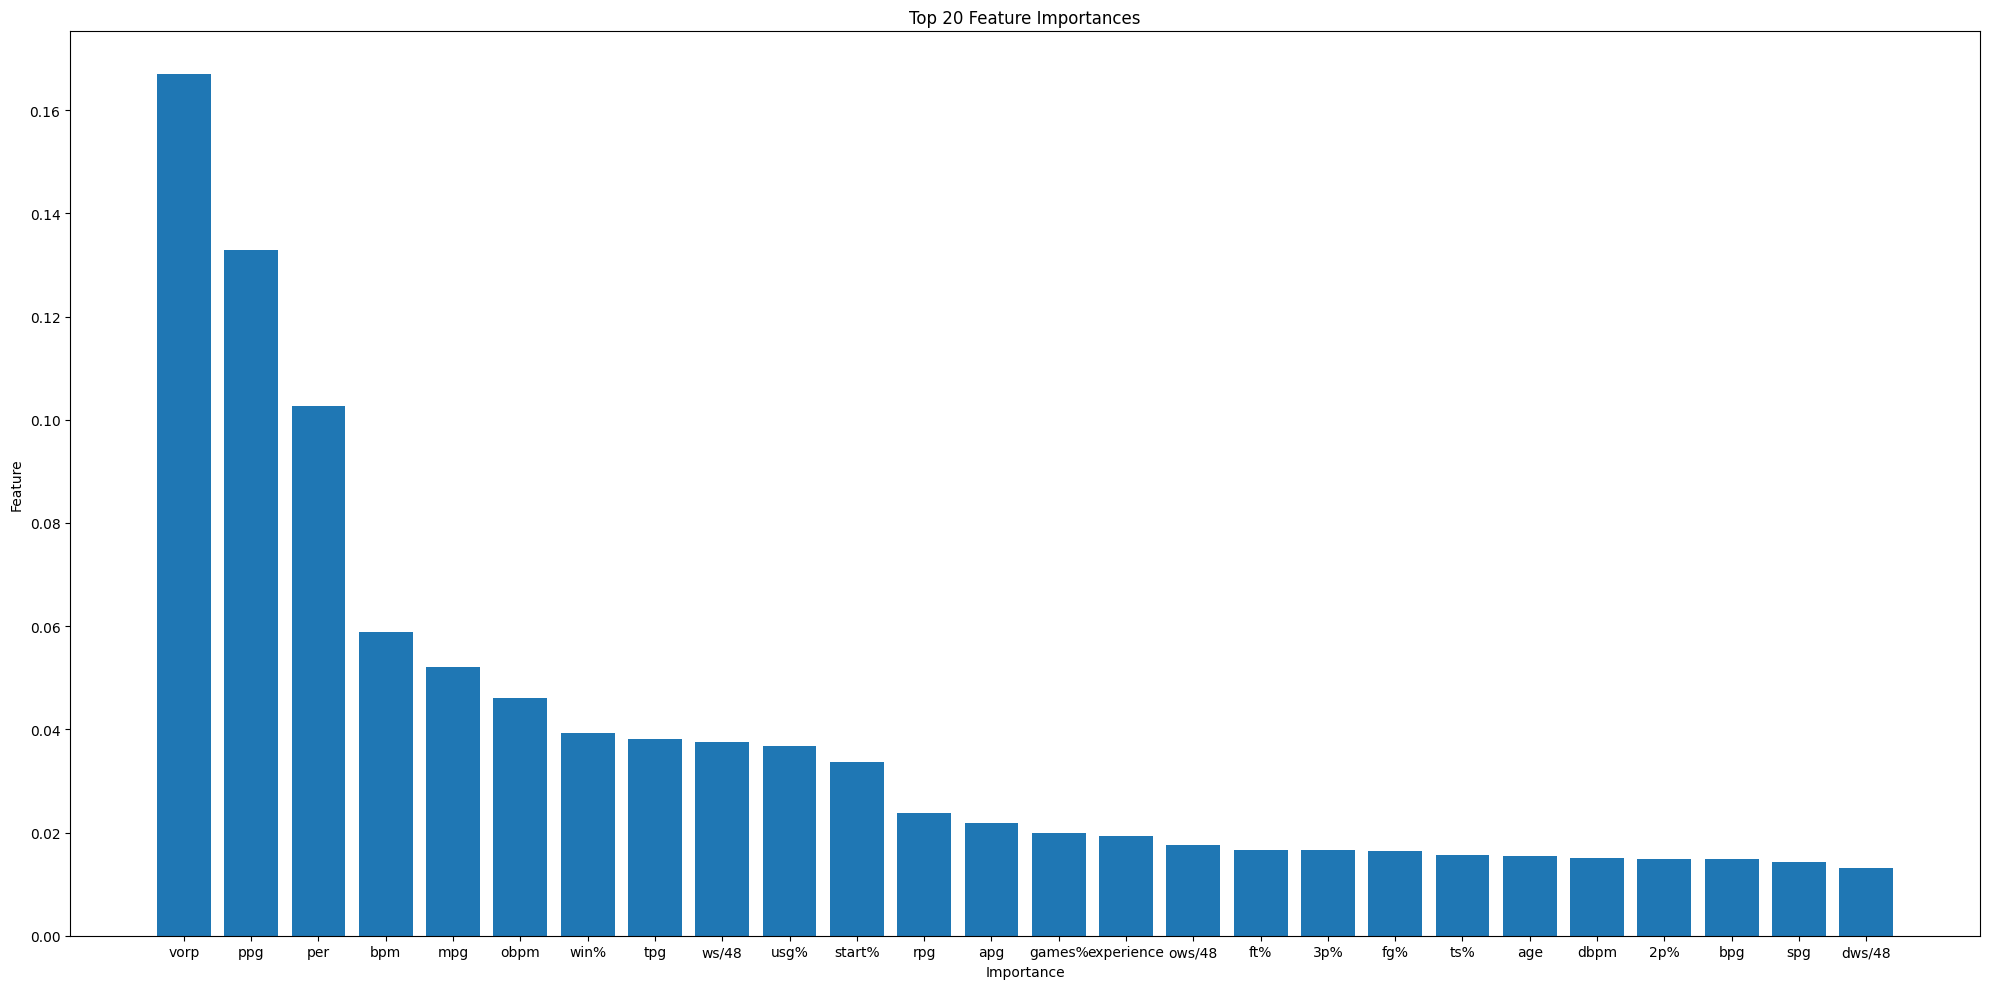

In [98]:
# Get feature importances
feature_importances = rfc.feature_importances_
# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_features = feature_importance_df
# Visualize 
plt.figure(figsize=(20, 10))
plt.bar(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

I will create the same model now using important features.

In [99]:
features = ['vorp', 'ppg', 'per', 'bpm', 'mpg', 'tpg', 'win%', 'usg%', 'ws/48', 'start%', 'rpg', 'apg', 'games%',
            'experience', 'ft%', 'ts%', 'fg%']

In [100]:
total_precision = 0
runs = 20
for _ in range(runs):
    unique_seasons = seasons['season'].unique()
    np.random.shuffle(unique_seasons)
    num_train_seasons = int(0.7 * len(unique_seasons))  # 80% for training
    train_seasons = unique_seasons[:num_train_seasons]
    test_seasons = unique_seasons[num_train_seasons:]
    
    # Put into train and test groups
    train = seasons[seasons['season'].isin(train_seasons)]
    test = seasons[seasons['season'].isin(test_seasons)]
    
    # Scale groups
    sc = StandardScaler()
    x_train = sc.fit_transform(train[features])
    x_test = sc.transform(test[features])
    
    # Train the model
    rfc = RandomForestClassifier(n_estimators=200)
    rfc.fit(x_train, train['all star'])
    
    # Get probabilities
    all_star_prob = rfc.predict_proba(x_test)[:, 1] # only the positive class (all stars)
    test_results = test.copy() # getting warnings so I had to make a copy
    test_results['all star prob'] = all_star_prob
    test_results['rank'] = test_results.groupby(['season', 'conference'])['all star prob'].rank(ascending=False).round(0)
    
    # Create a predicted column indicating whether the model predicted them to be an all star or not
    test_results['predicted'] = test_results['rank'] <= 12 # 12 all stars in each conference
    
    # calculate model precision
    precision_rate = predicted_AS_precision(test_results)
    total_precision += precision_rate

average_precision = total_precision / runs
print("Precision Score:", average_precision)

Precision Score: 0.742545912962768


The precision is still the same. I need to make a bigger adjustment.

## Model 3

For this model, I will add positions as an indicator variable using an encoder. I expect this to make a big difference, considering each position has different general expectations in terms of statistics (centers get rebounds, point guards get assists, etc).

In [101]:
# Match to general positions because strict position lines have always been blurred. 
position_mapping = {
    'SG-SF': 'G',
    'C-PF': 'C',
    'SF-SG': 'F',
    'PG-SG': 'G',
    'PF-SF': 'F',
    'SG-PG': 'G',
    'SF-PF': 'F',
    'PF-C': 'F',
    'C-F': 'C',
    'F-C': 'F',
    'G-F': 'G',
    'F-G': 'F',
    'SG' : 'G',
    'PF' : 'F',
    'PG' : 'G',
    'SF' : 'F',
    'C' : 'C',
    'SF-C': 'F',
    'SG-PF': 'F',
    'SG-PG-SF': 'G',
    'PG-SF' : 'G'
}
# Create a new column 'general pos' by mapping the 'pos' column using the dictionary
seasons['pos'] = seasons['pos'].map(position_mapping).fillna(seasons['pos'])

I will make the model with functions now so it can be saved and reused. This is based off what I already created in the Hall of Fame model. 

In [102]:
def encode_and_scale(data, features, response_variable):
    position_column = data['pos']
    encoder = OneHotEncoder(sparse_output=False)
    position_encoded = encoder.fit_transform(position_column.values.reshape(-1, 1))
    position_feature_names = encoder.get_feature_names_out(['pos'])
    position_df = pd.DataFrame(position_encoded, columns=position_feature_names)
    # Exclude position columns from scaling
    position_columns = list(position_df.columns)
    feature_columns = [col for col in features if col != 'pos']
    player_id = data['player_id']
    data.reset_index(drop=True, inplace=True)
    data_with_position = pd.concat([data, position_df], axis=1)
    x = data_with_position[feature_columns]  # Use feature_columns instead of features
    y = data_with_position[response_variable]
    sc = StandardScaler()
    x_scaled = sc.fit_transform(x)
    return x_scaled, y, player_id

def train_random_forest(data, features, response_variable, n_estimators, save_path):
    x, y, _ = encode_and_scale(data, features, response_variable)
    rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rfc.fit(x, y)
    # Save the trained model
    joblib.dump(rfc, save_path)

def load_and_predict(saved_model_path, new_player_data, features, response_variable):
    loaded_model = joblib.load(saved_model_path)
    x, y, id = encode_and_scale(new_player_data, features, response_variable)
    all_star_prob = loaded_model.predict_proba(x)[:, 1] # only the positive class (all stars)
    test_results = test.copy() # getting warnings so I had to make a copy
    test_results['all star prob'] = all_star_prob
    test_results['rank'] = test_results.groupby(['season', 'conference'])['all star prob'].rank(ascending=False).round(0)
    test_results['predicted'] = test_results['rank'] <= 12
    return test_results

In [103]:
total_precision = 0
runs = 20
for _ in range(runs):
    # Same train/test splitting as before
    unique_seasons = seasons['season'].unique()
    np.random.shuffle(unique_seasons)
    num_train_seasons = int(0.8 * len(unique_seasons))  # 80% for training
    train_seasons = unique_seasons[:num_train_seasons]
    test_seasons = unique_seasons[num_train_seasons:]
    train = seasons[seasons['season'].isin(train_seasons)]
    test = seasons[seasons['season'].isin(test_seasons)]
    # assign features and response variable
    features = ['vorp', 'ppg', 'per', 'bpm', 'mpg', 'tpg', 'win%', 'usg%', 'ws/48', 'start%', 'rpg', 'apg', 'games%',
                'experience', 'ft%', 'ts%', 'fg%', 'pos']
    response = 'all star'

    # Train the model
    train_random_forest(train, features, response, n_estimators=200, save_path='AS_model.pkl')
    # Test the model
    test_results = load_and_predict('AS_model.pkl', test, features, response)

    # calculate model precision
    precision_rate = predicted_AS_precision(test_results)
    total_precision += precision_rate

average_precision = total_precision / runs
print("Precision Score:", average_precision)

Precision Score: 0.7412583386692122


The model is still not improving, so I am going to try a logistic regression model instead. 

## Logistic Regression Model

I am going to use essentially the same steps in the model, except a logistic regression this time. With this model, I discovered shortening the seasons to the last 20 years instead of 40 makes the model more precise. Statistics are likely a lot different in the last 20 years than they were 20 years prior. 

In [117]:
def encode_and_scale(data, features, response_variable):
    position_column = data['pos']
    encoder = OneHotEncoder(sparse_output=False)
    position_encoded = encoder.fit_transform(position_column.values.reshape(-1, 1))
    position_feature_names = encoder.get_feature_names_out(['pos'])
    position_df = pd.DataFrame(position_encoded, columns=position_feature_names)
    # Exclude position columns from scaling
    position_columns = list(position_df.columns)
    feature_columns = [col for col in features if col != 'pos']
    data.reset_index(drop=True, inplace=True)
    data_with_position = pd.concat([data, position_df], axis=1)
    x = data_with_position[feature_columns]  # Use feature_columns instead of features
    y = data_with_position[response_variable]
    sc = StandardScaler()
    x_scaled = sc.fit_transform(x)
    return x_scaled, y

def train_logistic_regression(data, features, response_variable, save_path):
    x, y = encode_and_scale(data, features, response_variable)
    lr = LogisticRegression(random_state=42)
    lr.fit(x, y)
    # Save the trained model
    joblib.dump(lr, save_path)

def load_and_predict_lr(saved_model_path, new_player_data, features, response_variable):
    loaded_model = joblib.load(saved_model_path)
    x, y = encode_and_scale(new_player_data, features, response_variable)
    all_star_prob = loaded_model.predict_proba(x)[:, 1]  # only the positive class (all stars)
    test_results = test.copy()  # getting warnings so I had to make a copy
    test_results['all star prob'] = all_star_prob
    test_results['rank'] = test_results.groupby(['season', 'conference'])['all star prob'].rank(ascending=False).round(0)
    test_results['predicted'] = test_results['rank'] <= 12
    return test_results

In [118]:
total_precision = 0
runs = 100
for _ in range(runs):
    # Same train/test splitting as before
    unique_seasons = seasons['season'].unique()
    np.random.shuffle(unique_seasons)
    num_train_seasons = int(0.8 * len(unique_seasons))  # 80% for training
    train_seasons = unique_seasons[:num_train_seasons]
    test_seasons = unique_seasons[num_train_seasons:]
    train = seasons[seasons['season'].isin(train_seasons)]
    test = seasons[seasons['season'].isin(test_seasons)]
    # assign features and response variable
    features = ['vorp', 'ppg', 'per', 'bpm', 'mpg', 'tpg', 'win%', 'usg%', 'ws/48', 'start%', 'rpg', 'apg', 'games%',
                'experience', 'ts%', 'pos']
    response = 'all star'
    # Train the model
    train_logistic_regression(train, features, response, save_path='AS_model.pkl')
    # Test the model
    test_results = load_and_predict_lr('AS_model.pkl', test, features, response)

    # calculate model precision
    precision_rate = predicted_AS_precision(test_results)
    total_precision += precision_rate

average_precision = total_precision / runs
print("Precision Score:", average_precision)

Precision Score: 0.8051666666666667


This precision score improved the most so far, and it ran much faster. A logistic regression appears to fit this data far better than the random forest did. 

I will test this model one more time without the position indicator variable to see if that works better. There is a chance it is overcomplicating the model. 

## Logistic Regression Model 2

To do this, I have to change the encode_and_scale function, but the rest can stay the same. 

In [128]:
def encode_and_scale(data, features, response_variable):
    x = data[features]  # Use feature_columns instead of features
    y = data[response_variable]
    sc = StandardScaler()
    x_scaled = sc.fit_transform(x)
    return x_scaled, y

In [129]:
total_precision = 0
runs = 100
for _ in range(runs):
    # Same train/test splitting as before
    unique_seasons = seasons['season'].unique()
    np.random.shuffle(unique_seasons)
    num_train_seasons = int(0.8 * len(unique_seasons))  # 80% for training
    train_seasons = unique_seasons[:num_train_seasons]
    test_seasons = unique_seasons[num_train_seasons:]
    train = seasons[seasons['season'].isin(train_seasons)]
    test = seasons[seasons['season'].isin(test_seasons)]
    # assign features and response variable
    features = ['vorp', 'ppg', 'per', 'bpm', 'mpg', 'tpg', 'win%', 'usg%', 'ws/48', 'start%', 'rpg', 'apg', 'games%',
                'experience', 'ts%']
    response = 'all star'
    # Train the model
    train_logistic_regression(train, features, response, save_path='AS_model2.pkl')
    # Test the model
    test_results = load_and_predict_lr('AS_model2.pkl', test, features, response)

    # calculate model precision
    precision_rate = predicted_AS_precision(test_results)
    total_precision += precision_rate

average_precision = total_precision / runs
print("Precision Score:", average_precision)

Precision Score: 0.8080833333333333


These models were about the same, so I will use the 2nd model without position for the next steps because there appears to be no need to overcomplicate it. 

I am going to have it predict the most recent season's all-star game and assess its accuracy myself by potentially identifying why some of the mistakes are being made. 

In [130]:
test = seasons[seasons['season'] == 2023]
test_results = load_and_predict_lr('AS_model2.pkl', test, features, response)
test_results.sort_values(by='rank', ascending=True).head(24)

,Unnamed: 0,season,player_id,player,pos,age,experience,team,games,starts,mp,fg,fga,fg%,3pm,3pa,3p%,2pm,2pa,2p%,ft,fta,ft%,trb,ast,stl,blk,tov,pts,ppg,apg,rpg,spg,bpg,all star,MVP,DPOY,MVP share,DPOY share,per,ts%,usg%,ows,dws,ws,obpm,dbpm,bpm,vorp,win%,conference,mpg,ws/48,ows/48,dws/48,games%,start%,tpg,all star prob,rank,predicted
234,306,2023,4417,Joel Embiid,C,28.0,7,PHI,66,66.0,2284.0,728,1328,0.548,66.0,200.0,0.330,662,1128,0.587,661,771,0.857,670.0,274,66.0,112.0,226.0,2183,33.1,4.2,10.2,1.0,1.7,True,True,False,0.915,0.014,31.4,0.655,0.370,8.4,3.9,12.3,6.8,2.3,9.2,6.4,0.659000,east,34.6,0.26,0.18,0.08,0.804878,1.000000,3.424242,0.999824,1.0,True
371,506,2023,4352,Nikola Jokić,C,27.0,8,DEN,69,69.0,2323.0,646,1022,0.632,57.0,149.0,0.383,589,873,0.675,341,415,0.822,817.0,678,87.0,47.0,247.0,1690,24.5,9.8,11.8,1.3,0.7,True,False,False,0.674,0.000,31.5,0.701,0.272,11.2,3.8,14.9,8.5,4.5,13.0,8.8,0.646000,west,33.7,0.31,0.23,0.08,0.841463,1.000000,3.579710,0.999831,1.0,True
321,422,2023,4654,Luka Dončić,G,23.0,5,DAL,66,66.0,2391.0,719,1449,0.496,185.0,541.0,0.342,534,908,0.588,515,694,0.742,569.0,529,90.0,33.0,236.0,2138,32.4,8.0,8.6,1.4,0.5,True,False,False,0.010,0.000,28.7,0.609,0.376,7.3,2.9,10.2,7.6,1.4,9.0,6.6,0.463000,west,36.2,0.20,0.15,0.06,0.804878,1.000000,3.575758,0.998114,2.0,True
152,207,2023,4164,Giannis Antetokounmpo,F,28.0,10,MIL,63,63.0,2024.0,707,1278,0.553,47.0,171.0,0.275,660,1107,0.596,498,772,0.645,742.0,359,52.0,51.0,246.0,1959,31.1,5.7,11.8,0.8,0.8,True,False,False,0.606,0.028,29.0,0.605,0.388,4.9,3.7,8.6,5.8,2.7,8.5,5.4,0.707000,east,32.1,0.20,0.12,0.09,0.768293,1.000000,3.904762,0.999817,2.0,True
314,415,2023,3463,LeBron James,F,38.0,20,LAL,55,54.0,1954.0,609,1219,0.500,121.0,377.0,0.321,488,842,0.580,251,327,0.768,457.0,375,50.0,32.0,178.0,1590,28.9,6.8,8.3,0.9,0.6,True,False,False,0.000,0.000,23.9,0.583,0.333,3.2,2.4,5.6,5.5,0.6,6.1,4.0,0.524000,west,35.5,0.14,0.08,0.06,0.670732,0.981818,3.236364,0.994160,3.0,True
220,291,2023,4518,Jayson Tatum,F,24.0,6,BOS,74,74.0,2732.0,727,1559,0.466,240.0,686.0,0.350,487,873,0.558,531,622,0.854,649.0,342,78.0,51.0,213.0,2225,30.1,4.6,8.8,1.1,0.7,True,False,False,0.280,0.000,23.7,0.607,0.327,6.2,4.3,10.5,4.8,0.7,5.5,5.1,0.695000,east,36.9,0.18,0.11,0.08,0.902439,1.000000,2.878378,0.997666,3.0,True
289,381,2023,3770,Kevin Durant,F,34.0,15,TOT,47,47.0,1672.0,483,862,0.560,93.0,230.0,0.404,390,632,0.617,307,334,0.919,313.0,235,34.0,67.0,156.0,1366,29.1,5.0,6.7,0.7,1.4,True,False,False,0.000,0.000,25.9,0.677,0.307,4.7,2.1,6.8,6.0,1.2,7.1,3.9,0.492212,east,35.6,0.20,0.13,0.06,0.573171,1.000000,3.319149,0.983561,4.0,True
440,598,2023,3903,Stephen Curry,G,34.0,14,GSW,56,56.0,1941.0,559,1133,0.493,273.0,639.0,0.427,286,494,0.579,257,281,0.915,341.0,352,52.0,20.0,179.0,1648,29.4,6.3,6.1,0.9,0.4,True,False,False,0.005,0.000,24.1,0.656,0.310,5.8,2.0,7.8,7.5,0.1,7.6,4.7,0.537000,west,34.7,0.19,0.14,0.05,0.682927,1.000000,3.196429,0.987045,4.0,True
201,267,2023,3880,James Harden,G,33.0,14,PHI,58,58.0,2135.0,371,842,0.441,161.0,418.0,0.385,210,424,0.495,313,361,0.867,354.0,618,71.0,31.0,195.0,1216,21.0,10.7,6.1,1.2,0.5,False,False,False,0.000,0.000,21.6,0.607,0.250,5.8,2.6,8.4,5.1,0.3,5.4,4.0,0.659000,east,36.8,0.19,0.13,0.06,0.707317,1.000000,3.362069,0.983132,5.0,True
83,103,2023,4077,Damian Lillard,G,32.0,11,POR,58,58.0,2107.0,556,1202,0.463,244.0,658.0,0.371,312,544,0.574,510,558,0.914,277.0,425,50.0,18.0,191.0,1866,32.2,7.3,4.8,0.9,0.3,True,False,False,0.000,0.000,26.7,0.645,0.338,8.2,0.8,9.0,8.3,-1.2,7.1,4.9,0.402000,west,36.3,0.21,0.19,0.02,0.707317,1.000000,3.293103,0.978498,5.0,True


This year was below-average precision, likely because there were so many injuries and players resting, so there were quite a few misses. The incorrect predictions were: Trae Young, Kawhi Leonard, Devin Booker, Anthony Davis, Jimmy Butler, and James Harden.
#### Personal Insights:
    - Trae Young should have made it in my opinion, he was very underrated last season. This comes down to the ASG being more of a popularity vote than statistical-output based.
    - Leonard, Booker, and Davis suffered injuries in the first half of the season, so they were not selected. Their all-star-level play in the second half of the season caused the model to include them.
    - Butler and Harden both were not great in the first-half of the season, but played a lot better later on. 

These seem likee reasonable mistakes to me, but to consider my model accurate, the next few players left out on the rankings should be the actual all-stars. If this is the case, I can conclude my model still has a strong ranking system, despite these mistakes.

In [138]:
# the 24 to 28 ranked players (13 and 14 in each conference)
test_results.sort_values(by='rank', ascending=True).iloc[24:28] 

,Unnamed: 0,season,player_id,player,pos,age,experience,team,games,starts,mp,fg,fga,fg%,3pm,3pa,3p%,2pm,2pa,2p%,ft,fta,ft%,trb,ast,stl,blk,tov,pts,ppg,apg,rpg,spg,bpg,all star,MVP,DPOY,MVP share,DPOY share,per,ts%,usg%,ows,dws,ws,obpm,dbpm,bpm,vorp,win%,conference,mpg,ws/48,ows/48,dws/48,games%,start%,tpg,all star prob,rank,predicted
389,524,2023,4437,Pascal Siakam,C,28.0,7,TOR,71,71.0,2652.0,630,1313,0.480,93.0,287.0,0.324,537,1026,0.523,367,474,0.774,556.0,415,65.0,36.0,169.0,1720,24.2,5.8,7.8,0.9,0.5,True,False,False,0.000,0.0,20.3,0.565,0.272,5.2,2.6,7.8,3.3,-0.1,3.1,3.5,0.500,east,37.4,0.14,0.09,0.05,0.865854,1.0,2.380282,0.756632,13.0,False
98,127,2023,4489,De'Aaron Fox,G,25.0,6,SAC,73,73.0,2435.0,682,1331,0.512,119.0,367.0,0.324,563,964,0.584,343,440,0.780,306.0,447,83.0,23.0,181.0,1826,25.0,6.1,4.2,1.1,0.3,True,False,False,0.002,0.0,21.8,0.599,0.301,5.5,1.8,7.4,3.4,-0.9,2.5,2.7,0.585,west,33.4,0.15,0.11,0.04,0.890244,1.0,2.479452,0.702593,13.0,False
501,677,2023,4803,Zion Williamson,F,22.0,3,NOP,29,29.0,956.0,285,469,0.608,7.0,19.0,0.368,278,450,0.618,177,248,0.714,202.0,133,32.0,16.0,99.0,754,26.0,4.6,7.0,1.1,0.6,True,False,False,0.000,0.0,25.2,0.652,0.304,2.3,1.2,3.6,4.8,1.0,5.8,1.9,0.512,west,33.0,0.18,0.12,0.06,0.353659,1.0,3.413793,0.644417,14.0,False
106,135,2023,3872,DeMar DeRozan,F,33.0,14,CHI,74,74.0,2682.0,657,1303,0.504,46.0,142.0,0.324,611,1161,0.526,456,523,0.872,343.0,377,83.0,36.0,153.0,1816,24.5,5.1,4.6,1.1,0.5,True,False,False,0.000,0.0,20.6,0.592,0.278,5.4,3.2,8.5,1.7,0.3,2.0,2.6,0.488,east,36.2,0.15,0.10,0.06,0.902439,1.0,2.067568,0.659296,14.0,False


All of these players were all-stars, but barely missed the cut on my predictions (ranked 13/14). This makes me more comfortable with the ranking system my model has developed because all of the all-stars were captured near the top of the rankings. If only first-half of the season data was used, most of the mistaken predictions would drop out and these next 4 players would slip in. 

Considering this, I expect the model to be very precise when I predict the 2024 all-stars halfway through the season.

#### In January of the 2023-2024 season, I will come back to this model and use it to predict who will be in the next all-star game. Afterwards, I will assess its accuracy and potentially identify players that the fan-vote or coach-selection missed.